In [2]:
# %% Parte 1 — Setup
import sys, warnings, time
from pathlib import Path
from datetime import datetime
import pandas as pd

warnings.filterwarnings("ignore")
pd.set_option("display.max_colwidth", 180)

def log(msg): print(f"[{datetime.now().strftime('%H:%M:%S')}] {msg}")

def find_core(max_up=5, manual=None):
    if manual:
        c = Path(manual)
        if (c / "__init__.py").exists() and (c / "pipeline.py").exists():
            if str(c.parent) not in sys.path: sys.path.insert(0, str(c.parent))
            return c
    here = Path(".").resolve()
    for _ in range(max_up+1):
        cand = here / "core"
        if (cand / "__init__.py").exists() and (cand / "pipeline.py").exists():
            if str(cand.parent) not in sys.path: sys.path.insert(0, str(cand.parent))
            return cand
        here = here.parent
    return None

# Se o notebook estiver em app/, não precisa mexer
MANUAL_CORE_DIR = None  # ex.: r"C:\...\underground-truck-optimizer\core"
core_dir = find_core(manual=MANUAL_CORE_DIR)
assert core_dir is not None, "Não achei a pasta 'core/'. Coloque o .ipynb dentro de app/ (irmão de core/)."
log(f"core localizado em: {core_dir}")

import core, inspect
import core.pipeline as _cp
log(f"import core OK — de: {Path(inspect.getfile(_cp)).parent}")

PROJECT_ROOT = Path(core.__file__).resolve().parent.parent
DATA_DIR = PROJECT_ROOT / "data" / "raw"   # ajuste se precisar
log(f"DATA_DIR = {DATA_DIR}")

# KNOBS globais (pode ajustar quando quiser)
RUN = {
    "T_op_min": 720,            # min úteis do turno (12h = 720min)
    "N_MC": 1000,                  # 0 desliga MC nesta exploração
    "beta_softcap": 0.10,       # β
    "underutil_penalty": 0.05,  # μ
    "overshoot_penalty_ton": 0.00001,  # λ
    "ignore_outliers_flag": True,
    "eqps_habilitados": None,   # None → usa available==1
    "sa_params": {"T0":1.0, "Tf":1e-3, "iters":6000, "moves_per_iter":1, "random_state":42},
}
MOV_ID_REQUIRED = "Producao Final Minerio"  # ou None para não filtrar

[20:54:04] core localizado em: C:\Users\vmatos\OneDrive - Alvarez and Marsal\Desktop\Aplicativo de Sistema de Apoio à Decisão\dss-optimizer-underground-mine\core
[20:54:04] import core OK — de: C:\Users\vmatos\OneDrive - Alvarez and Marsal\Desktop\Aplicativo de Sistema de Apoio à Decisão\dss-optimizer-underground-mine\core
[20:54:04] DATA_DIR = C:\Users\vmatos\OneDrive - Alvarez and Marsal\Desktop\Aplicativo de Sistema de Apoio à Decisão\dss-optimizer-underground-mine\data\raw


In [3]:
# %% Parte 2 — Leitura + validação
from core.io import load_from_data_dir

tic = time.time()
log("Lendo via core.io.load_from_data_dir(...)")
pkg = load_from_data_dir(DATA_DIR)
df_frota  = pkg["df_frota"].copy()
df_ciclo  = pkg["df_ciclo"].copy()
df_inputs = (pkg.get("df_inputs") or pd.DataFrame()).copy()
log(f"Leitura OK em {time.time()-tic:.2f}s")

# Filtro por movimento (se houver)
if MOV_ID_REQUIRED and "mov_id" in df_ciclo.columns:
    b = len(df_ciclo)
    df_ciclo = df_ciclo[df_ciclo["mov_id"].astype(str).str.strip()==MOV_ID_REQUIRED].copy()
    log(f"Filtro mov_id=='{MOV_ID_REQUIRED}': {b} → {len(df_ciclo)}")

# Schemas mínimos
req_frota  = {"eqp_id","cap_ton"}
req_ciclo  = {"eqp_id","od_id","cycle_min"}
req_inputs = {"od_id","eqp_min","eqp_max","w_od","mass_target_ton"}

def _has(df, cols): 
    cl = set(map(str.lower, getattr(df, "columns", pd.Index([])).str.lower()))
    return cols - cl

miss = {
    "frota":  sorted(_has(df_frota,  req_frota)),
    "ciclo":  sorted(_has(df_ciclo,  req_ciclo)),
    "inputs": sorted(_has(df_inputs, req_inputs)) if not df_inputs.empty else ["(vazio)"],
}
assert not miss["frota"], f"Frota faltando: {miss['frota']}"
assert not miss["ciclo"], f"Ciclo faltando: {miss['ciclo']}"

# Fallback para inputs se vazio
if df_inputs.empty:
    ods = df_ciclo["od_id"].dropna().astype(str).unique().tolist()
    df_inputs = pd.DataFrame({"od_id": ods, "eqp_min":1, "eqp_max":99, "w_od":1.0, "mass_target_ton":500.0})
    log("⚠ df_inputs vazio — criado fallback genérico (meta=500, min=1, max=99, w=1.0)")

# Prints e sanidade
log(f"Frota: {df_frota.shape} | Ciclo: {df_ciclo.shape} | Inputs: {df_inputs.shape}")
display(df_frota.head(5)); display(df_ciclo.head(5)); display(df_inputs.head(5))

assert df_frota["cap_ton"].gt(0).all(), "cap_ton deve ser >0"
assert df_ciclo["cycle_min"].gt(0).all(), "cycle_min deve ser >0"
assert df_inputs["eqp_max"].ge(df_inputs["eqp_min"]).all(), "eqp_max < eqp_min em algum OD"
log("Sanidades básicas: OK")

[20:54:04] Lendo via core.io.load_from_data_dir(...)
[20:54:04] Leitura OK em 0.56s
[20:54:04] Filtro mov_id=='Producao Final Minerio': 4875 → 4875
[20:54:04] ⚠ df_inputs vazio — criado fallback genérico (meta=500, min=1, max=99, w=1.0)
[20:54:04] Frota: (19, 6) | Ciclo: (4875, 5) | Inputs: (19, 5)


,eqp_id,cap_ton,df_pct,uf_pct,modelo,available
0,CW-107,38.0,0.415640,0.112547,AD45,1
1,CW-108,38.0,0.199621,0.330758,AD45,1
2,CW-109,38.0,0.589333,0.852348,AD45,1
3,CW-110,38.0,0.064344,0.719931,AD45,1
4,CW-111,38.0,0.902328,0.351959,AD45,1


,eqp_id,od_id,cycle_min,mov_id,is_outlier
0,CW-107,11 SER - 09 GRADE,26.0,Producao Final Minerio,False
1,CW-107,11 SER - 09 GRADE,45.0,Producao Final Minerio,False
2,CW-107,16 BAL - 11 GRADE,500.0,Producao Final Minerio,True
3,CW-107,23 FGS - 11 GRADE,109.0,Producao Final Minerio,False
4,CW-107,23 FGS - 11 GRADE,77.0,Producao Final Minerio,False


,od_id,eqp_min,eqp_max,w_od,mass_target_ton
0,11 SER - 09 GRADE,1,99,1.0,500.0
1,16 BAL - 11 GRADE,1,99,1.0,500.0
2,23 FGS - 11 GRADE,1,99,1.0,500.0
3,15 BAL - 11 GRADE,1,99,1.0,500.0
4,16 BAL - 09 GRADE,1,99,1.0,500.0


[20:54:04] Sanidades básicas: OK


In [4]:
# %% Parte 3 — Selecionar ODs e limites por OD (SUBSTITUIR ESTA CÉLULA)
SELECT_ODS = [
    "22 SER - 11 GRADE",
    "23 FGS - 11 GRADE",
]

EQP_LIMITS_BY_OD = {
    "22 SER - 11 GRADE": {"eqp_max": 3, "eqp_min": 1, "w_od": 1.00, "mass_target_ton": 400},
    "23 FGS - 11 GRADE": {"eqp_max": 2, "eqp_min": 1, "w_od": 0.90, "mass_target_ton": 380},
}

# (Opcional) restringir pares (od, eqp). Se não quiser, deixe {}.
ALLOWED_EQPS_BY_OD = {
    # "22 SER - 11 GRADE": ["CW-107","CW-108"],
    # "23 FGS - 11 GRADE": ["CW-109"]
}

# ---------- aplica seleção/limites ----------
import pandas as pd

sel_set = set(SELECT_ODS)

# 1) filtra ciclo
b = len(df_ciclo)
df_ciclo = df_ciclo[df_ciclo["od_id"].astype(str).isin(sel_set)].copy()
log(f"[OD] ciclo filtrado: {b} → {len(df_ciclo)}")

# 2) *** filtra inputs apenas para as ODs escolhidas ***
df_inputs = df_inputs[df_inputs["od_id"].astype(str).isin(sel_set)].copy()

# 3) cria inputs que faltarem (com defaults) e aplica overrides
defaults = {"eqp_min": 1, "eqp_max": 99, "w_od": 1.0, "mass_target_ton": 500.0}
present = set(df_inputs["od_id"].astype(str))
missing = sel_set - present
add_rows = []
for od in sorted(missing):
    base = defaults.copy()
    if od in EQP_LIMITS_BY_OD:
        base.update(EQP_LIMITS_BY_OD[od])
    add_rows.append({"od_id": od, **base})
if add_rows:
    df_inputs = pd.concat([df_inputs, pd.DataFrame(add_rows)], ignore_index=True)

# aplica overrides nas que já existiam
df_inputs = df_inputs.set_index("od_id")
for od, patch in EQP_LIMITS_BY_OD.items():
    if od in df_inputs.index:
        for k, v in patch.items():
            df_inputs.loc[od, k] = v
df_inputs = df_inputs.reset_index()

# 4) (opcional) restringe eqps por OD
if ALLOWED_EQPS_BY_OD:
    keep = {(od, eqp) for od, lst in ALLOWED_EQPS_BY_OD.items() for eqp in lst}
    bb = len(df_ciclo)
    df_ciclo = df_ciclo[df_ciclo.apply(lambda r: (str(r["od_id"]), str(r["eqp_id"])) in keep, axis=1)].copy()
    log(f"[OD] eqps permitidos aplicados: {bb} → {len(df_ciclo)}")

# 5) ordena inputs na ordem escolhida
order_map = {od:i for i, od in enumerate(SELECT_ODS)}
df_inputs["__ord"] = df_inputs["od_id"].astype(str).map(order_map).fillna(9999)
df_inputs = df_inputs.sort_values("__ord").drop(columns="__ord")

# 6) sanidades pós-filtro
assert df_inputs["eqp_max"].ge(df_inputs["eqp_min"]).all(), "eqp_max < eqp_min em alguma OD"
od_to_n_eqp = df_ciclo.groupby("od_id")["eqp_id"].nunique()
warn = []
for _, r in df_inputs.iterrows():
    need = int(r["eqp_min"]); have = int(od_to_n_eqp.get(str(r["od_id"]), 0))
    if have < need: warn.append(f"{r['od_id']}: tem {have} eqps no ciclo, precisa {need}")
if warn: log("⚠ Cobertura mínima possivelmente inviável: " + " | ".join(warn))

log(f"[OD] Selecionadas: {SELECT_ODS}")
display(df_inputs)

[20:54:05] [OD] ciclo filtrado: 4875 → 596
[20:54:05] [OD] Selecionadas: ['22 SER - 11 GRADE', '23 FGS - 11 GRADE']


,od_id,eqp_min,eqp_max,w_od,mass_target_ton
1,22 SER - 11 GRADE,1,3,1.0,400.0
0,23 FGS - 11 GRADE,1,2,0.9,380.0


In [5]:
# %% Parte 4 — Greedy + Evaluate (SUBSTITUIR ESTA CÉLULA)
from core.greedy import greedy_allocation
from core.evaluate import evaluate_allocation, EvalParams

# 4.0) eqps do dia (lista) — se None, usa available==1; SENÃO usa todos
if RUN["eqps_habilitados"] is None and "available" in df_frota.columns:
    eqps_dia = df_frota.loc[df_frota["available"]==1,"eqp_id"].dropna().astype(str).unique().tolist()
else:
    eqps_dia = RUN["eqps_habilitados"]  # pode ser None → então não filtra por eqp

log(f"eqps_habilitados: {eqps_dia if eqps_dia is not None else '(todos os eqps da frota)'}")

# 4.1) *** filtra df_frota/df_ciclo pelos eqps do dia (greedy NÃO recebe esse parâmetro) ***
if eqps_dia is not None:
    df_frota_run = df_frota[df_frota["eqp_id"].astype(str).isin(eqps_dia)].copy()
    df_ciclo_run = df_ciclo[df_ciclo["eqp_id"].astype(str).isin(eqps_dia)].copy()
else:
    df_frota_run, df_ciclo_run = df_frota.copy(), df_ciclo.copy()

log(f"frota p/ greedy: {df_frota_run.shape} | ciclo p/ greedy: {df_ciclo_run.shape}")

# 4.2) Greedy
alloc_greedy = greedy_allocation(
    df_frota=df_frota_run,
    df_ciclo=df_ciclo_run,
    df_inputs=df_inputs,
    T_op_min=int(RUN["T_op_min"]),
    ignore_outliers_flag=bool(RUN["ignore_outliers_flag"])
)
log(f"Greedy alocações: {len(alloc_greedy)}")
display(alloc_greedy.head(10))

# 4.3) Evaluate (com breakdown de FO)
params = EvalParams(
    overshoot_penalty_ton=float(RUN["overshoot_penalty_ton"]),
    ignore_outliers_flag=bool(RUN["ignore_outliers_flag"]),
    beta_softcap=float(RUN["beta_softcap"]),
    underutil_penalty=float(RUN["underutil_penalty"]),
    debug=True
)
greedy_eval = evaluate_allocation(
    df_alloc_in=alloc_greedy[["eqp_id","od_id"]],
    df_inputs=df_inputs,
    df_frota=df_frota_run,
    df_ciclo=df_ciclo_run,
    T_op_min=int(RUN["T_op_min"]),
    params=params
)

by_od = greedy_eval["by_od"].copy()
cols = [c for c in ["od_id","n_eqp","ton_total","target_t","w_od","att_ratio","att_value","excesso_t","throughput_tph","tempo_para_meta_h"] if c in by_od.columns]
display(by_od[cols])

w_term = (by_od["w_od"] * by_od["att_value"]).sum()
excesso_term = by_od.get("excesso_t", pd.Series(0.0)).sum()
lambda_, mu_ = params.overshoot_penalty_ton, params.underutil_penalty
underutil_sum = greedy_eval.get("underutil_sum", 0.0)
fo_check = w_term - lambda_*excesso_term - mu_*underutil_sum

log(f"FO (Greedy): {greedy_eval['objective']:.4f} | Viável: {greedy_eval['feasible']}")
log(f"Σ w*att_value={w_term:.4f}  | λ*Σ excesso={lambda_*excesso_term:.4f}  | μ*underutil={mu_*underutil_sum:.4f}")
if greedy_eval["violations"]: log(f"Violações: {greedy_eval['violations']}")

[20:54:05] eqps_habilitados: ['CW-107', 'CW-108', 'CW-109', 'CW-110', 'CW-111', 'CW-112', 'CW-113', 'CW-114', 'CW-115', 'CW-117', 'CW-118', 'CW-120', 'CW-121', 'CW-122', 'CW-123', 'JQ-CW-042', 'JQ-CW-043', 'JQ-CW-046', 'JQ-CW-051']
[20:54:05] frota p/ greedy: (19, 6) | ciclo p/ greedy: (596, 5)
[20:54:05] Greedy alocações: 5


,eqp_id,od_id,ciclos,ton_estimado
0,CW-115,22 SER - 11 GRADE,8.217391,197.217391
1,CW-121,22 SER - 11 GRADE,8.014248,192.341941
2,CW-109,22 SER - 11 GRADE,7.578947,288.000000
3,CW-123,23 FGS - 11 GRADE,7.748107,185.954564
4,CW-122,23 FGS - 11 GRADE,7.741935,185.806452


,od_id,ton_total,target_t,w_od,att_ratio,att_value,excesso_t,throughput_tph,tempo_para_meta_h
0,22 SER - 11 GRADE,330.0,400.0,1.0,0.825000,0.825000,0.0,16.608899,14.545455
1,23 FGS - 11 GRADE,144.0,380.0,0.9,0.378947,0.378947,0.0,12.667895,31.666667


[20:54:05] FO (Greedy): 1.1334 | Viável: True
[20:54:05] Σ w*att_value=1.1661  | λ*Σ excesso=0.0000  | μ*underutil=0.0327


[20:57:13] FO (SA best): 1.1700 | Viável: True | Underutil_sum: 0.5477983092020104


,eqp_id,od_id,cycle_min,cap_ton,T_ef_min,n_trips,ton_estimado,used_min
0,CW-109,23 FGS - 11 GRADE,91.500000,38.0,361.667985,3,114.0,274.500000
1,CW-111,22 SER - 11 GRADE,101.250000,38.0,228.659339,2,76.0,202.500000
2,CW-115,22 SER - 11 GRADE,87.619048,24.0,450.735748,5,120.0,438.095238
3,CW-121,23 FGS - 11 GRADE,89.250000,24.0,379.728244,4,96.0,357.000000
4,JQ-CW-051,22 SER - 11 GRADE,93.000000,28.0,311.550993,3,84.0,279.000000


,od_id,ton_total,viagens_total,eqp_alocados,target_t,w_od,att_ratio,att_value,excesso_t,throughput_tph,rate_elapsed_tph,tempo_para_meta_h,tempo_para_meta_min,viavel_no_turno
0,22 SER - 11 GRADE,280.0,10,3,400.0,1.0,0.700000,0.700000,0.0,16.953496,23.333333,17.142857,1028.571429,False
1,23 FGS - 11 GRADE,210.0,7,2,380.0,0.9,0.552632,0.552632,0.0,16.994961,17.500000,21.714286,1302.857143,False


,iter,T,obj,best_obj
0,0,1.000000,1.133367,1.133367
1,1,0.998849,1.133367,1.133367
2,2,0.997700,1.133367,1.133367
3,3,0.996552,1.133367,1.133367
4,4,0.995405,1.133367,1.133367
5,5,0.994260,1.133367,1.133367
6,6,0.993116,1.133367,1.133367
7,7,0.991973,1.133367,1.133367
8,8,0.990832,1.133367,1.133367
9,9,0.989692,1.133367,1.133367


[20:57:13] Saltos de best:


,iter,T,obj,best_obj
2619,2619,0.049034,1.133959,1.133959
2636,2636,0.048084,1.138738,1.138738
2736,2736,0.042855,1.143734,1.143734
2801,2801,0.039765,1.167060,1.167060
4786,4786,0.004046,1.167149,1.167149
5186,5186,0.002553,1.169979,1.169979


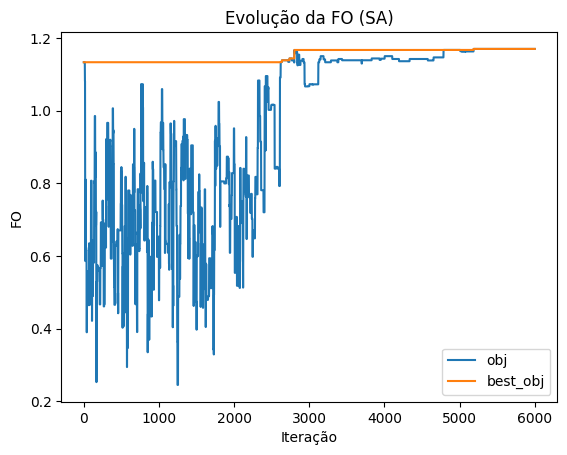

In [6]:
# %% Parte 5 — SA: evolução + saltos de best
from core.sa import run_sa, SAParams
import pandas as pd

sa_params = SAParams(
    T0=RUN["sa_params"]["T0"], Tf=RUN["sa_params"]["Tf"],
    iters=RUN["sa_params"]["iters"], moves_per_iter=RUN["sa_params"]["moves_per_iter"],
    random_state=RUN["sa_params"]["random_state"],
    overshoot_penalty_ton=float(RUN["overshoot_penalty_ton"]),
    beta_softcap=float(RUN["beta_softcap"]),
    underutil_penalty=float(RUN["underutil_penalty"]),
    ignore_outliers_flag=bool(RUN["ignore_outliers_flag"]),
)

sa_res = run_sa(
    df_frota=df_frota, df_ciclo=df_ciclo, df_inputs=df_inputs,
    T_op_min=int(RUN["T_op_min"]),
    start_alloc=alloc_greedy[["eqp_id","od_id"]],
    params=sa_params
)
best_eval = sa_res["best_eval"]

log(f"FO (SA best): {best_eval['objective']:.4f} | Viável: {best_eval['feasible']} | Underutil_sum: {best_eval.get('underutil_sum')}")
display(sa_res["best_alloc"].head(10))
display(best_eval["by_od"].sort_values("w_od", ascending=False))

hist = pd.DataFrame(sa_res["history"])
display(hist.head(10))
jumps = hist.loc[hist["best_obj"].diff().fillna(0) > 0]
log("Saltos de best:"); display(jumps)

# gráfico simples (opcional)
try:
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(hist["iter"], hist["obj"], label="obj")
    plt.plot(hist["iter"], hist["best_obj"], label="best_obj")
    plt.xlabel("Iteração"); plt.ylabel("FO"); plt.title("Evolução da FO (SA)")
    plt.legend(); plt.show()
except Exception as e:
    log(f"Matplotlib indisponível: {e}")

[21:03:19] [sens] eqp_max em '22 SER - 11 GRADE':


,eqp_max,FO_greedy,FO_sa,att_sum_greedy,att_sum_sa,underutil_sa,feasible_sa
0,1,0.780923,0.780923,0.797368,0.797368,0.328915,True
1,2,0.953275,0.965793,0.980526,0.992368,0.531504,True
2,3,1.133367,1.170569,1.166053,1.202368,0.635984,True
3,4,1.133367,1.354849,1.166053,1.392368,0.750387,True


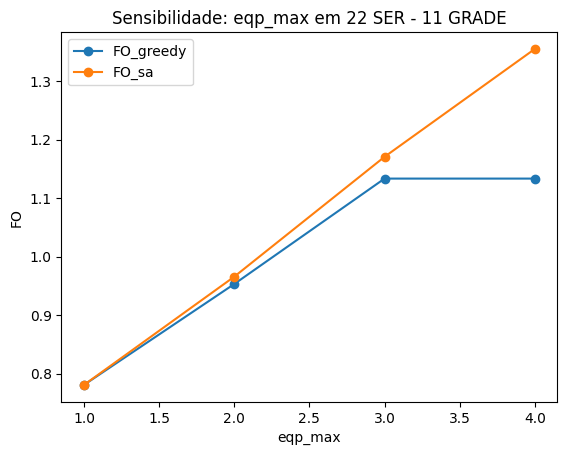

In [7]:
# %% Parte 6 — Sensibilidade eqp_max por OD (robusta)
import copy
import pandas as pd
from core.greedy import greedy_allocation
from core.evaluate import evaluate_allocation, EvalParams
from core.sa import run_sa, SAParams

TARGET_OD = "22 SER - 11 GRADE"   # OD que você quer estudar
GRID = [1, 2, 3, 4]               # valores de eqp_max para testar

# SA mais rápida p/ experimentos
RUN_LOCAL = copy.deepcopy(RUN)
RUN_LOCAL["N_MC"] = 0
RUN_LOCAL["sa_params"]["iters"] = max(100, RUN_LOCAL["sa_params"]["iters"]//2)

rows = []
for vmax in GRID:
    # copia inputs e aplica mudança só na OD-alvo
    din = df_inputs.copy()
    mask = din["od_id"].astype(str) == TARGET_OD
    if not mask.any():
        log(f"[sens] OD '{TARGET_OD}' não está em df_inputs; pulando valor {vmax}.")
        continue
    din.loc[mask, "eqp_max"] = int(vmax)

    # --- Greedy com os DFs já filtrados (da Parte 4) ---
    alloc_g = greedy_allocation(
        df_frota=df_frota_run if "df_frota_run" in globals() else df_frota,
        df_ciclo=df_ciclo_run if "df_ciclo_run" in globals() else df_ciclo,
        df_inputs=din,
        T_op_min=int(RUN_LOCAL["T_op_min"]),
        ignore_outliers_flag=bool(RUN_LOCAL["ignore_outliers_flag"])
    )

    ge = evaluate_allocation(
        df_alloc_in=alloc_g[["eqp_id","od_id"]],
        df_inputs=din,
        df_frota=(df_frota_run if "df_frota_run" in globals() else df_frota),
        df_ciclo=(df_ciclo_run if "df_ciclo_run" in globals() else df_ciclo),
        T_op_min=int(RUN_LOCAL["T_op_min"]),
        params=EvalParams(
            overshoot_penalty_ton=float(RUN_LOCAL["overshoot_penalty_ton"]),
            ignore_outliers_flag=bool(RUN_LOCAL["ignore_outliers_flag"]),
            beta_softcap=float(RUN_LOCAL["beta_softcap"]),
            underutil_penalty=float(RUN_LOCAL["underutil_penalty"]),
            debug=False
        )
    )

    sa_res2 = run_sa(
        df_frota=(df_frota_run if "df_frota_run" in globals() else df_frota),
        df_ciclo=(df_ciclo_run if "df_ciclo_run" in globals() else df_ciclo),
        df_inputs=din,
        T_op_min=int(RUN_LOCAL["T_op_min"]),
        start_alloc=alloc_g[["eqp_id","od_id"]],
        params=SAParams(
            T0=RUN_LOCAL["sa_params"]["T0"], Tf=RUN_LOCAL["sa_params"]["Tf"],
            iters=RUN_LOCAL["sa_params"]["iters"], moves_per_iter=RUN_LOCAL["sa_params"]["moves_per_iter"],
            random_state=RUN_LOCAL["sa_params"]["random_state"],
            overshoot_penalty_ton=float(RUN_LOCAL["overshoot_penalty_ton"]),
            beta_softcap=float(RUN_LOCAL["beta_softcap"]),
            underutil_penalty=float(RUN_LOCAL["underutil_penalty"]),
            ignore_outliers_flag=bool(RUN_LOCAL["ignore_outliers_flag"]),
        )
    )
    se = sa_res2["best_eval"]

    # recomputa atendimento ponderado (só para inspeção)
    att_g = (ge["by_od"]["w_od"]*ge["by_od"]["att_value"]).sum()
    att_s = (se["by_od"]["w_od"]*se["by_od"]["att_value"]).sum()

    rows.append({
        "eqp_max": vmax,
        "FO_greedy": ge["objective"],
        "FO_sa": se["objective"],
        "att_sum_greedy": att_g,
        "att_sum_sa": att_s,
        "underutil_sa": se.get("underutil_sum", 0.0),
        "feasible_sa": se.get("feasible", None)
    })

sens = pd.DataFrame(rows).sort_values("eqp_max")
log(f"[sens] eqp_max em '{TARGET_OD}':")
display(sens)

# (opcional) gráfico
try:
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(sens["eqp_max"], sens["FO_greedy"], marker="o", label="FO_greedy")
    plt.plot(sens["eqp_max"], sens["FO_sa"], marker="o", label="FO_sa")
    plt.xlabel("eqp_max"); plt.ylabel("FO"); plt.title(f"Sensibilidade: eqp_max em {TARGET_OD}")
    plt.legend(); plt.show()
except Exception as e:
    log(f"[sens] Matplotlib indisponível: {e}")